# U-Net Pretraining for FSS

In [2]:
!pip install -q segmentation_models_pytorch
!pip install -q wandb --upgrade

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import random
from glob import glob
import os, shutil
import gc
from PIL import Image
from typing import Dict, List, Tuple, Any, Optional
from collections import namedtuple, defaultdict
from IPython import display as ipd
import copy

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
from tqdm import tqdm
tqdm.pandas()

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# Config

In [4]:
class config:
    seed          = 42
    exp_name      = 'unet'
    model_name    = 'Unet'
    base_model    = 'efficientnet-b0'
    train_bs      = 64
    valid_bs      = 2 * train_bs
    image_size    = [224, 224]
    comment       = f'model-{model_name}|base-{base_model}|dim-{image_size[0]}x{image_size[1]}'
    epochs        = 10
    learning_rate = 3e-4
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Seeding

In [5]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('>>> SEEDED <<<')

set_seed(config.seed)

>>> SEEDED <<<


# Data

In [6]:
image_paths = sorted(glob('/kaggle/input/uwmgi-png/processed-v1/imgs/*.png'))
masks_paths = sorted(glob('/kaggle/input/uwmgi-png/processed-v1/masks/*.png'))

In [7]:
def get_id(lst):
    return [x.split('/')[-1].split('.')[0] for x in lst]

df = pd.DataFrame({
    'id': get_id(image_paths),
    'image_paths': image_paths, 
    'mask_paths': masks_paths
})

df = df.sample(frac=1).reset_index(drop=True)

df['kfold'] = -1

kf = KFold(n_splits=config.n_fold)

for fold, (train, valid) in enumerate(kf.split(df)):
    df.loc[valid, 'kfold'] = fold
    
df.sample(10)

,id,image_paths,mask_paths,kfold
14050,case55_day0_slice_0073,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,4
6908,case36_day14_slice_0046,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,2
7812,case11_day13_slice_0049,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,2
15774,case130_day20_slice_0061,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,4
13818,case67_day12_slice_0095,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,4
3409,case142_day14_slice_0062,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,1
2230,case145_day0_slice_0065,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,0
14277,case65_day0_slice_0103,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,4
6554,case144_day15_slice_0068,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,1
4461,case67_day12_slice_0106,/kaggle/input/uwmgi-png/processed-v1/imgs/case...,/kaggle/input/uwmgi-png/processed-v1/masks/cas...,1


# Utils

In [8]:
def rle_decode(mask_rle, shape):
    '''
    Extracted from: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
    
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def rle_encode(img):
    '''
    Extracted from: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
    
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def plot_batch_sample(batch: Dict[str, torch.Tensor]) -> None:
    plt.subplot(121)
    plt.imshow(batch['image'].permute(1,2,0).detach().numpy().astype(np.uint8))
    
    plt.subplot(122)
    plt.imshow(batch['mask'].permute(1,2,0).detach().numpy().astype(np.uint8))

    plt.tight_layout()
    plt.show()


def plot_batch(imgs, msks, size=3):
    '''Extracted from: https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-train-pytorch'''
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()
#         img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()
        img = (0.5 * img + 0.5 * msk) # .astype(np.uint8)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

# Dataset

In [9]:
class UWMGIDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mode: str = "train") -> None:
        super(UWMGIDataset, self).__init__()
        self.df = df
        self.image_paths = df['image_paths'].to_list()
        self.masks_paths = df['mask_paths'].to_list()
        self.mode = mode
        
        self.transforms = None
        
        if self.mode == "train":
            self.transforms = A.Compose([
                A.Resize(height=config.image_size[0], width=config.image_size[1], interpolation=0),
                A.Rotate(limit=90, p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ColorJitter(p=0.5),
#                 A.Normalize(),
                ToTensorV2()
            ], p=1.0)
        elif self.mode == "valid":
            self.transforms = A.Compose([
                A.Resize(height=config.image_size[0], width=config.image_size[1], interpolation=0),
                A.Normalize(),
                ToTensorV2()
            ], p=1.0)
        else:
            raise NotImplementedError(f"The case where mode={self.mode} has not been implemented try from ['train', 'valid']")
    
    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, ix: int) -> Dict[str, torch.Tensor]:
        image_path = self.image_paths[ix]
        mask_path = self.masks_paths[ix]
        
        image = np.array(Image.open(image_path))[:, :, :-1] 
        mask = np.array(Image.open(mask_path))[:, :, :-1]
        
#         print(image.shape, mask.shape)
#         print(image.max(), image.min(), mask.min(), mask.max())
        
        transformed = self.transforms(image=image, mask=mask)
        image = torch.tensor(transformed['image'], dtype=torch.float32, device=config.device)
        mask = torch.tensor(transformed['mask'], dtype=torch.float32, device=config.device)
        mask = mask.permute(2, 0, 1)
        return {
            "image": image / 255.0,
            "mask": mask / 255.0
        }

# Dataloaders

In [10]:
def build_dataloaders(fold: int) -> Tuple[DataLoader]:
    train_df = df[df.kfold != fold]
    valid_df = df[df.kfold == fold]
    
    train_dataset = UWMGIDataset(df=train_df, mode="train")
    valid_dataset = UWMGIDataset(df=valid_df, mode="valid")
    
    train_dataloader = DataLoader(
        dataset=train_dataset, 
        batch_size=config.train_bs, 
        shuffle=True, 
    )
    valid_dataloader = DataLoader(
        dataset=valid_dataset, 
        batch_size=config.valid_bs, 
        shuffle=False
    )
    
    return train_dataloader, valid_dataloader

In [11]:
train_loader, valid_loader = build_dataloaders(fold=0)

In [12]:
batch = next(iter(train_loader))
{k:v.shape for k,v in batch.items()}

{'image': torch.Size([64, 3, 224, 224]), 'mask': torch.Size([64, 3, 224, 224])}

In [13]:
{k: v.min() for k, v in batch.items()}

{'image': tensor(0., device='cuda:0'), 'mask': tensor(0., device='cuda:0')}

In [14]:
{k: v.max() for k, v in batch.items()}

{'image': tensor(1., device='cuda:0'), 'mask': tensor(1., device='cuda:0')}

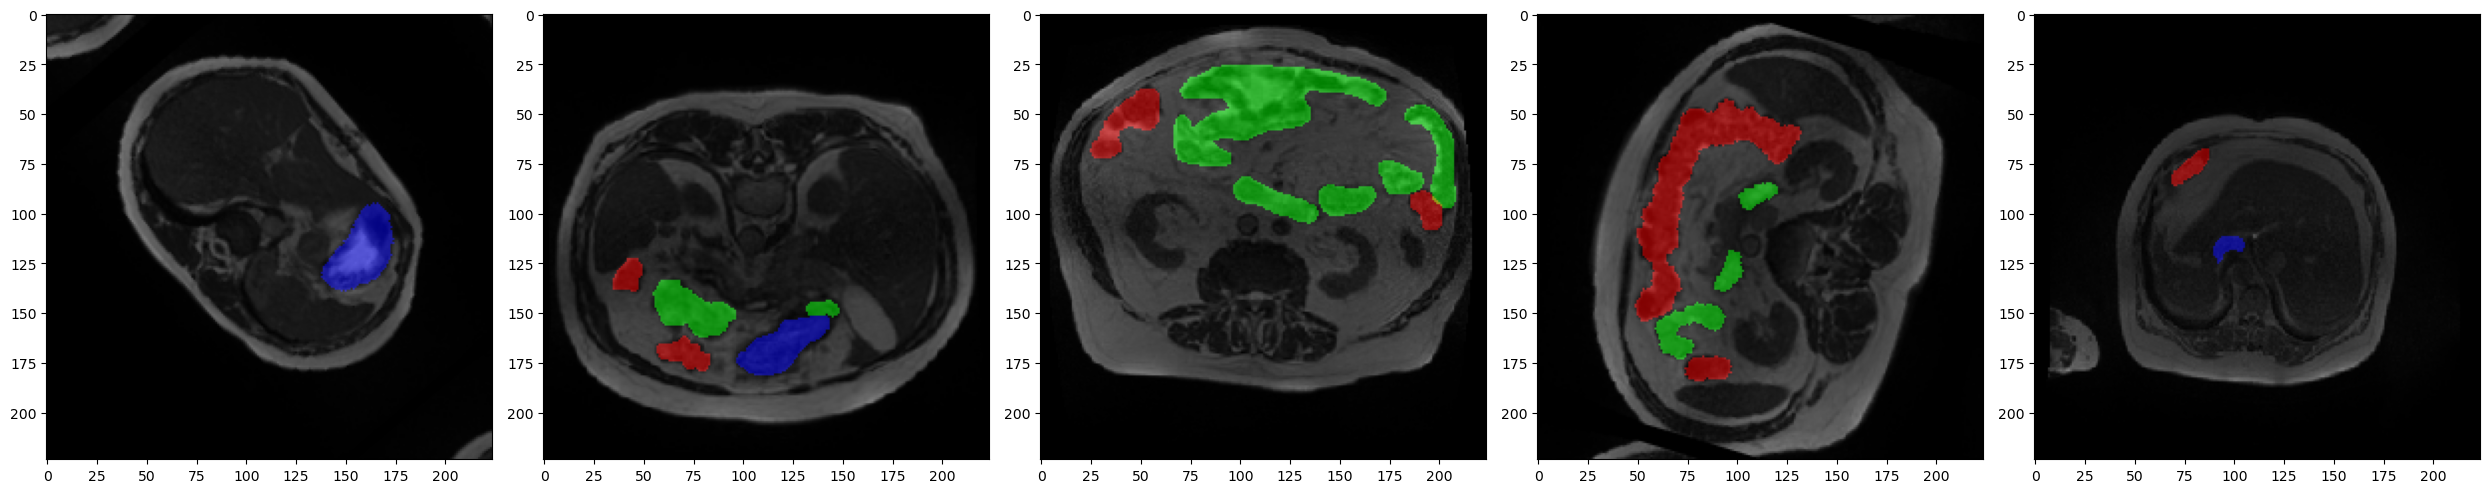

In [15]:
plot_batch(batch['image'].detach().cpu(), batch['mask'].detach().cpu(), size=5)

In [16]:
gc.collect()

16561

# Model

In [17]:
def build_model() -> nn.Module:
    return smp.Unet(
        encoder_name=config.base_model, 
        encoder_weights='imagenet',
        in_channels=3, 
        classes=config.num_classes,
        activation=None
    ).to(config.device)

def load_model(path: str):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# Loss Functions

In [18]:
def dice_coef(y_pred: torch.Tensor, y_true: torch.Tensor, thr: float = 0.5, eps: float = 1e-6) -> torch.Tensor:
    y_true = y_true.to(dtype=torch.float32)
    y_pred = (y_pred > thr).to(dtype=torch.float32)
    intersection = 2.0 * (y_true * y_pred).sum() + eps
    denominator  = y_pred.sum() + y_true.sum() + eps
    dice = intersection / denominator
    return dice.mean()

def iou_coef(y_pred: torch.Tensor, y_true: torch.Tensor, thr: float = 0.5, eps: float = 1e-6) -> torch.Tensor:
    y_true = y_true.to(dtype=torch.float32)
    y_pred = (y_pred > thr).to(dtype=torch.float32)
    intersection = (y_true * y_pred).sum() + eps
    union        = y_true.sum() + y_pred.sum() - intersection + eps
    return intersection / union

bce_loss = smp.losses.SoftBCEWithLogitsLoss()
tversky_loss = smp.losses.TverskyLoss(mode='multilabel')

def loss_fn(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    return 0.5*bce_loss(y_pred, y_true) + 0.5*tversky_loss(y_pred, y_true)

# Schedulers

In [19]:
def get_scheduler(optimizer):
    '''Extracted from: https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-train-pytorch'''
    if config.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=config.T_max, 
                                                   eta_min=config.min_lr)
    elif config.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=config.T_0, 
                                                             eta_min=config.min_lr)
    elif config.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=config.min_lr,)
    elif config.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif config.scheduler == None:
        return None
        
    return scheduler

In [20]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = get_scheduler(optimizer)

# Training Function

In [21]:
def train_one_epoch(
    model: nn.Module, 
    optimizer: optim, 
    scheduler: lr_scheduler, 
    dataloader: DataLoader
) -> Tuple[float, float, float]:
    model.train()
    dataset_size = 0.0
    running_loss = 0.0
    
    coef = {
        'dice_coef': [],
        'iou_coef': []
    }
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, batch in pbar:
        images, masks = batch['image'], batch['mask']
        
        y_pred = model.forward(images)
        
        loss = loss_fn(y_pred=y_pred, y_true=masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
            
        running_loss += loss.item() * images.shape[0]
        dataset_size += images.shape[0]
        
        epoch_loss = running_loss / dataset_size
        current_lr = optimizer.param_groups[0]['lr']
        
        with torch.no_grad():
            coef['dice_coef'].append(dice_coef(y_pred=y_pred.cpu().detach(), y_true=masks.cpu().detach()))
            coef['iou_coef'].append(iou_coef(y_pred=y_pred.cpu().detach(), y_true=masks.cpu().detach()))
        
        pbar.set_postfix(
            train_loss=f'{epoch_loss:.3f}',
            lr=f'{current_lr:.5f}',
            dice=f'{np.mean(coef["dice_coef"]):.3f}',
            iou=f'{np.mean(coef["iou_coef"]):.3f}',
        )
    
    return epoch_loss, np.mean(coef['dice_coef']), np.mean(coef['iou_coef'])

# Validation Function

In [22]:
@torch.no_grad()
def valid_one_epoch(
    model: nn.Module, 
    dataloader: DataLoader
) -> Tuple[float, float, float]:
    model.eval()
    dataset_size = 0.0
    running_loss = 0.0
    
    coef = {
        'dice_coef': [],
        'iou_coef': []
    }
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, batch in pbar:
        images, masks = batch['image'], batch['mask']
        
        y_pred = model.forward(images)
        
        loss = loss_fn(y_pred=y_pred, y_true=masks)
            
        running_loss += loss.item() * images.shape[0]
        dataset_size += images.shape[0]
        
        epoch_loss = running_loss / dataset_size
        current_lr = optimizer.param_groups[0]['lr']
        
        coef['dice_coef'].append(dice_coef(y_pred=y_pred.cpu().detach(), y_true=masks.cpu().detach()))
        coef['iou_coef'].append(iou_coef(y_pred=y_pred.cpu().detach(), y_true=masks.cpu().detach()))
        
        pbar.set_postfix(
            train_loss=f'{epoch_loss:.3f}',
            dice=f'{np.mean(coef["dice_coef"]):.3f}',
            iou=f'{np.mean(coef["iou_coef"]):.3f}',
        )
    
    return epoch_loss, np.mean(coef['dice_coef']), np.mean(coef['iou_coef'])

# Run Training

In [23]:
def run_training(
    model: nn.Module, optimizer: optim, 
    train_loader: DataLoader, valid_loader: DataLoader,
    scheduler: lr_scheduler = None, fold: int = 0, num_epochs: int = 10, 
):
    wandb.watch(model, log_freq=100)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -1
    best_epoch     = -1
    history        = defaultdict(list)
    
    for epoch in range(num_epochs):
        train_loss, train_dice, train_iou = train_one_epoch(
            model=model, 
            optimizer=optimizer, 
            scheduler=scheduler, 
            dataloader=train_loader
        )
        
        valid_loss, valid_dice, valid_iou = valid_one_epoch(
            model=model, 
            dataloader=valid_loader
        )
        
        wandb.log({
            'Train Loss'    : train_loss, 
            'Train Dice'    : train_dice, 
            'Train IoU'     : train_iou, 
            'Valid Loss'    : valid_loss, 
            'Valid Dice'    : valid_dice,
            'Valid IoU'     : valid_iou, 
            'Learning Rate' : scheduler.get_last_lr()[0]
        })
        
        history['Train Loss'].append(train_loss)
        history['Train Dice'].append(train_dice)
        history['Train IoU'].append(train_iou)
        history['Valid Loss'].append(valid_loss)
        history['Valid Dice'].append(valid_dice)
        history['Valid IoU'].append(valid_iou)
        
        print(f'Validation Dice: {valid_dice:.3f}  |  Validation IoU: {valid_iou:.3f}')
        
        if valid_dice >= best_dice:
            print(f'{c_}Validation Dice Score increased from {best_dice:0.4f} -> {valid_dice:0.4f}')
            best_epoch = epoch
            best_dice  = valid_dice
            
            best_model_wts = copy.deepcopy(model.state_dict())
            run.summary['Best Dice'] = best_dice
            run.summary['Best Epoch'] = best_epoch
            
            model_path = f'{config.comment}-fold-{fold}.bin'
            torch.save(best_model_wts, model_path)
            wandb.save(model_path)
    
    model.load_state_dict(best_model_wts)
    return model, history

In [24]:
config.device

device(type='cuda', index=0)

In [ ]:
for fold in range(config.n_fold):
    print('>'*15)
    print(f'>>> Fold #{fold + 1} <<<')
    print('<'*15)
    
    run = wandb.init(
        project='uwgmi',
        config={k:v for k, v in dict(vars(config)).items() if '__' not in k},
        name=f'fold-{fold}|{config.comment}',
        group=config.comment
    )
    
    train_loader, valid_loader = build_dataloaders(fold=fold)
    
    model = build_model()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.wd)
    scheduler = get_scheduler(optimizer)
    
    model, history = run_training(
        model=model, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        fold=fold, 
        num_epochs=config.epochs, 
        train_loader=train_loader, 
        valid_loader=valid_loader
    )
    
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

>>>>>>>>>>>>>>>
>>> Fold #1 <<<
<<<<<<<<<<<<<<<


wandb: Currently logged in as: aaparajit02. Use `wandb login --relogin` to force relogin


Train :  18%|█▊        | 38/208 [01:19<06:55,  2.45s/it, dice=0.043, iou=0.022, lr=0.00030, train_loss=0.793]